Apply LDA to classify spectral embeddings:
    
    Tools: scikit-learn 0.24.1


##  LDA

In [2]:
import os
from matplotlib import pyplot as plt
import pickle
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
import pandas as pd

### Loading array from files

In [3]:
## Loading embedding arrays
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv') as file_name:
    X_embedding = np.loadtxt(file_name, delimiter=",")
print(X_embedding.shape)

(16360, 300)


In [5]:
## Loading class labels
import csv

with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/y_npc_class_results_labels.csv') as file_name:
    csv_label = csv.reader(file_name)
    y_label_list = []
    for row in csv_label:
        y_label_list.append(row[0])
y_label = np.array(y_label_list)
print(y_label.shape)

(16360,)


## Perform LDA

#### Kick out 'Unclassified' group and the groups with size smaller than 4

In [6]:
# Kick out the unexpected groups
lbs = Counter(y_label)
lbs = {k:v for k,v in sorted(lbs.items(), key=lambda item: item[1], reverse=True)}
sel_index = list(lbs.values()).index(3) # find the first index whose values just smaller than 4
select_lbs = list(lbs.keys())[:sel_index]
select_lbs.remove('Unclassified')
print(len(select_lbs))

303


In [7]:
# Define the data

select_index = []
for i in select_lbs:
    temp_index, = np.where(y_label==i)
    #print(temp_index)
    select_index += list(temp_index)
select_index.sort()
#print(select_index)

y_label_2 = np.array(y_label[select_index])
print(y_label_2.shape)

X_embedding_2=X_embedding[select_index,:]
print(X_embedding_2.shape)

(12823,)
(12823, 300)


#### For training and test data

In [8]:
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_embedding_2, y_label_2, test_size = 0.25, random_state = 0, stratify=y_label_2)

# Apply Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Apply LDA
t0=time.process_time()
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train,y_train)
t1=time.process_time()-t0
print('Time elapsed: %.3f' % t1)

# Predict the test set results and check the accuracy
y_pred = lda_model.predict(X_test)
accuracy_lda = accuracy_score(y_test,y_pred)
print('Accuracy: %.3f' % accuracy_lda)

labels =list(np.unique(np.array(list(y_test)+list(y_pred))))
conf_mat = confusion_matrix(y_test,y_pred, labels = labels)
print(conf_mat)



Time elapsed: 11.887
Accuracy: 0.374
[[0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [12]:
print(conf_mat.shape)
len(y_test)

(303, 303)


3206

In [25]:
print(len(np.unique(y_test)))
print(len(np.unique(y_label_2)))

184
184


In [ ]:
# Plot Confusion matrix  # Ignore: this plot is too large to plot.
plt.figure(figsize = (30,27))
ax= plt.subplot()
df_cm = pd.DataFrame(conf_mat, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual labels'
df_cm.columns.name = 'Predicted labels'
sns.set(font_scale=1.8)
sns.heatmap(df_cm, annot=True, ax = ax, cmap="YlGnBu", fmt='d',annot_kws={"size": 10})



<AxesSubplot:xlabel='Predicted labels', ylabel='Actual labels'>

In [9]:
from calculate_accuracy19 import calculate_accuracy_per_label

In [10]:
labels_a = list(np.unique(np.array(list(y_test)+list(y_pred))))
accuracy_dict = calculate_accuracy_per_label(labels_a, conf_mat,list(y_train))
save_accuracy_file = open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label/CF_accuracy_LDA_subclass_allgroups.pickle', "wb")
pickle.dump(accuracy_dict, save_accuracy_file)
save_accuracy_file.close()

2 1
7 11
0 1
1 2
0 2
3 1
4 8
1 2
4 7
1 2
3 6
15 11
3 2
15 4
10 9
9 8
1 3
59 55
2 2
4 10
6 3
14 19
8 8
12 15
12 10
3 3
3 4
13 26
0 2
2 3
5 3
13 22
0 1
5 9
0 1
5 1
10 17
2 2
1 1
4 7
1 2
5 10
2 3
5 7
0 5
5 3
2 5
2 4
1 6
3 2
1 2
2 1
3 6
1 2
68 63
19 18
28 38
7 4
2 1
5 6
1 5
4 5
10 9
37 38
30 42
14 19
37 22
6 6
41 46
10 14
15 34
0 2
9 15
0 3
0 3
0 1
119 139
1 1
7 7
7 6
8 15
1 1
2 3
12 19
0 4
10 9
1 2
4 5
4 3
2 3
8 14
4 9
0 2
89 75
3 6
8 16
4 4
5 3
5 1
4 5
3 6
6 7
2 5
5 9
8 15
1 2
4 4
6 5
17 8
5 7
7 8
3 1
4 7
21 32
74 70
0 1
64 68
1 2
1 4
14 5
35 26
2 8
8 8
1 1
17 7
9 20
1 2
3 4
4 1
33 55
19 23
1 2
9 6
2 5
1 1
13 14
0 1
2 3
2 3
1 4
3 11
3 1
1 2
2 1
5 5
23 23
7 12
2 4
1 3
3 3
52 36
1 1
13 20
7 7
53 39
7 3
0 1
41 52
0 2
10 12
10 9
1 4
13 21
0 1
3 5
14 12
7 5
7 17
15 13
34 42
1 1
3 3
5 5
0 1
1 4
3 2
4 6
8 9
14 11
0 1
0 1
0 1
2 3
4 7
1 1
14 14
7 9
0 2
1 3
59 27
8 5
2 3
8 13
5 6
13 16
3 3
0 2
37 65
1 1
24 19
2 2
2 1
5 5
5 3
0 1
4 1
0 1
1 1
2 2
5 5
0 1
12 11
20 16
8 27
6 6
11 17
51 12
5 5
0 2
2 3


In [16]:
print(accuracy_dict.keys())

dict_keys(['labels', 'accuracy', 'predict_vs_test_size', 'group_size_pred', 'group_size_test', 'group_size_train'])


In [ ]:
npc_classes = npc_classes.reindex(npc_class_percentile_scores.index)

f, axes = plt.subplots(1, 2, figsize=(15, 18), gridspec_kw={'width_ratios': [2, 1]})
f.subplots_adjust(hspace=0.025, wspace=0.05)

fig1 = sns.barplot(x = accuracy_dict['group_size_train'], y = accuracy_dict['labels'], ax = axes[0])
fig1.set_xlabel('Number of compounds in each label')
fig1.set_title("Group size in NPClassifier classes by LDA", fontsize=18)
show_values_on_bars(fig1, "h", 0.3)

fig2 = sns.barplot(x = npc_classes.values, y = npc_classes.index, ax = axes[1], color = "#4C72B0")
fig2.set_title("Accuracy in NPClassifier classes by LDA", fontsize = 18)
fig2.set_xlabel("Predicted accuracy per label")
fig2.set_xlim(0,600)
show_values_on_bars(fig2, "h", 6)
fig2.set_yticklabels([]);

#plt.savefig(plot_dir+"Internal Jaccard similarity - NPClassifier classes.svg")

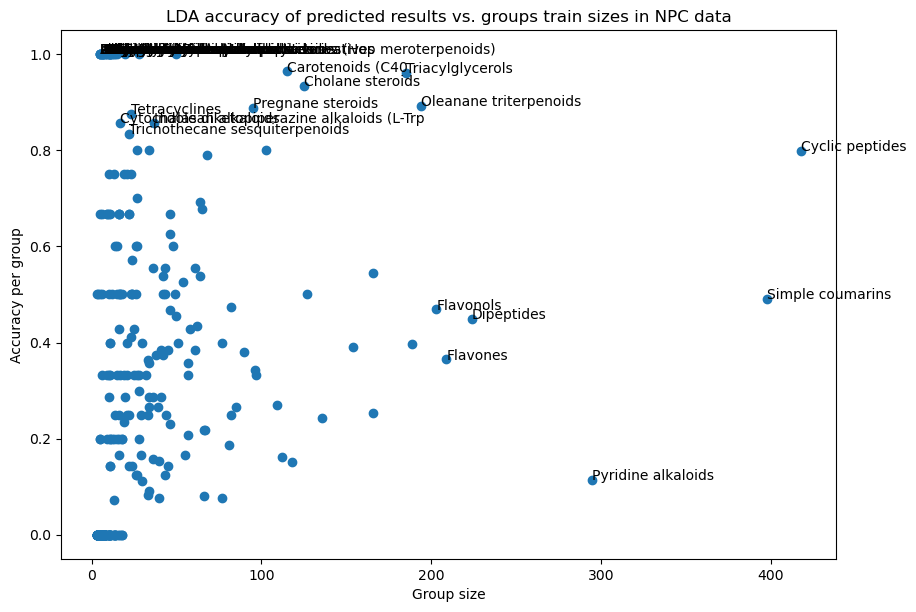

In [13]:
x= accuracy_dict['group_size_train']
y= accuracy_dict['accuracy']
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':100})
plt.scatter(x, y)

plt.title('LDA accuracy of predicted results vs. groups train sizes in NPC data')
plt.xlabel('Group size')
plt.ylabel('Accuracy per group')
for i,txt in enumerate(labels_a):
    if x[i] >= 200 or y[i]>0.8:
        plt.annotate(txt,(x[i],y[i]))
plt.show()

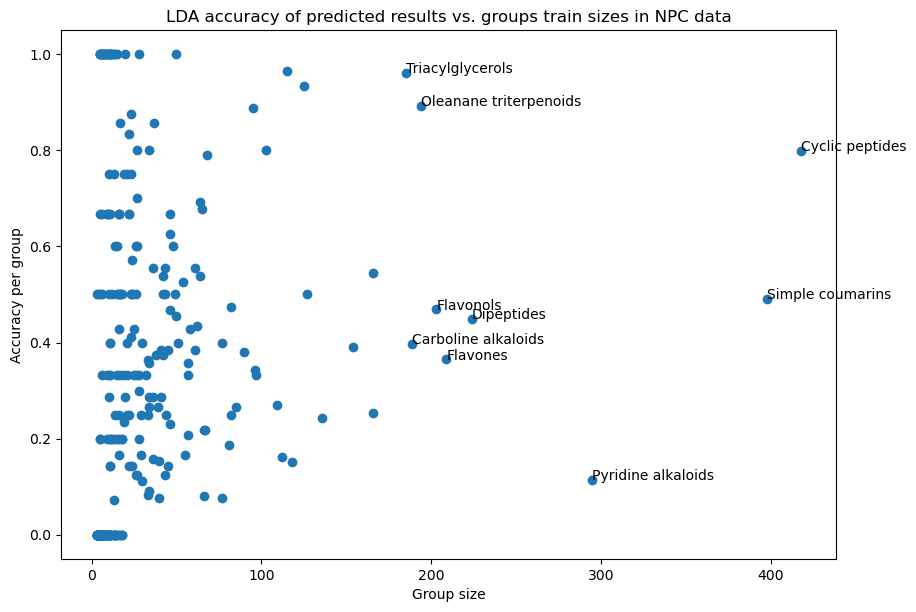

In [15]:
x= accuracy_dict['group_size_train']
y= accuracy_dict['accuracy']
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':100})
plt.scatter(x, y)

plt.title('LDA accuracy of predicted results vs. groups train sizes in NPC data')
plt.xlabel('Group size')
plt.ylabel('Accuracy per group')
for i,txt in enumerate(labels_a):
    if x[i] >= 170:
        plt.annotate(txt,(x[i],y[i]))
plt.show()

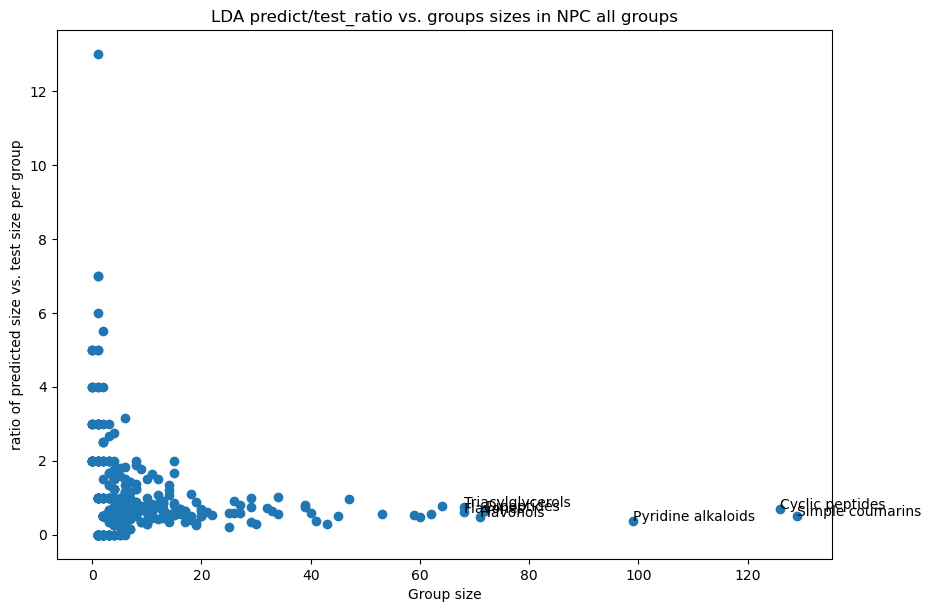

In [24]:
x= accuracy_dict['group_size_test']
y= accuracy_dict['predict_vs_test_size']
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':100})
plt.scatter(x, y)
plt.title('LDA predict/test_ratio vs. groups sizes in NPC all groups')
plt.xlabel('Group size')
plt.ylabel('ratio of predicted size vs. test size per group')
for i,txt in enumerate(labels_a):
    if x[i] > 65:
        plt.annotate(txt,(x[i],y[i]))
plt.show()

#### For the whole data

In [9]:
# LDA

t0=time.process_time()
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_embedding,y_label)
t1=time.process_time()-t0
print('Time elapsed: %.3f' % t1)

# make a prediction
yhat = lda_model.predict([X_embedding[500]])
# sumarize prediction
print('class no. 500 is %s' % y_label[500])
print('Predicted Class: %s' % yhat)


Time elapsed: 102.368
class no. 500 is Unclassified
Predicted Class: ['Unclassified']


##### Cross validation

In [10]:
t0=time.process_time()

k=10
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(lda_model, X_embedding, y_label, scoring='accuracy', cv=KFold(k))

t1=time.process_time()-t0
print('%d fold' % k)
print('Time elapsed: %.3f' % t1)
# summarize result
print('Mean Accuracy: %.3f (%.3f) \n' % (mean(scores), std(scores)))

10 fold
Time elapsed: 649.524
Mean Accuracy: 0.290 (0.079) 



In [11]:
## Try different K-folds
for i in range(20,21):

    t0=time.process_time()

    # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(lda_model, X_embedding, y_label, scoring='accuracy', cv=KFold(i))

    t1=time.process_time()-t0
    print('%d fold' % i)
    print('Time elapsed: ', t1)
    # summarize result
    print('Mean Accuracy: %.3f (%.3f) \n' % (mean(scores), std(scores)))

20 fold
Time elapsed:  1072.6938211320003
Mean Accuracy: 0.311 (0.112) 



## Take two major groups to do LDA again

In [12]:
# Define the data

select_lbs = ['Cyclic peptides','Simple coumarins']
select_index = []
for i in select_lbs:
    temp_index, = np.where(y_label==i)
    #print(temp_index)
    select_index += list(temp_index)
select_index.sort()
#print(select_index)

y_label_2_main = np.array(y_label[select_index])
print(y_label_2_main.shape)

X_embedding_2_lbs=X_embedding[select_index,:]
print(X_embedding_2_lbs.shape)

(1088,)
(1088, 300)


In [13]:
### perform LDA
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_embedding_2_lbs, y_label_2_main, test_size = 0.25, random_state = 0)
# Apply Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Apply LDA
t0=time.process_time()
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train,y_train)
t1=time.process_time()-t0
print('Time elapsed: %.3f' % t1)

# Predict the test set results and check the accuracy
y_pred = lda_model.predict(X_test)
accuracy_lda = accuracy_score(y_test,y_pred)
print('Accuracy: %.3f' % accuracy_lda)
conf_mat = confusion_matrix(y_test,y_pred)
print(conf_mat)

Time elapsed: 32.303
Accuracy: 0.904
[[112  14]
 [ 12 134]]


In [63]:
from collections import Counter
Counter(y_test)

Counter({'Unclassified': 817,
         'Erythromycins': 6,
         'Isoquinoline alkaloids': 53,
         'Linear peptides': 45,
         'Cyclic peptides': 126,
         'Chalcones': 43,
         'Cinnamic acids and derivatives': 40,
         'Flavanones': 22,
         'Triacylglycerols': 68,
         'Oleanane triterpenoids': 64,
         'Chromones': 17,
         'Pyrrolizidine alkaloids': 12,
         'Simple coumarins': 129,
         'Cardenolides': 16,
         'Aminosugars': 8,
         'Lathyrane diterpenoids': 4,
         'Isoindole alkaloids': 4,
         'Flavonols': 71,
         'Phenylalanine-derived alkaloids': 30,
         'Acetogenins': 4,
         'Pyridine alkaloids': 99,
         'Linear diarylheptanoids': 15,
         'Dipeptides': 72,
         'Disaccharides': 7,
         'Aurones': 10,
         'Tetracyclines': 10,
         'Germacrane sesquiterpenoids': 26,
         '3-acyl tetramic acids': 2,
         'Colensane and Clerodane diterpenoids': 18,
         'Pyrrol

<AxesSubplot:xlabel='Predicted labels', ylabel='Actual labels'>

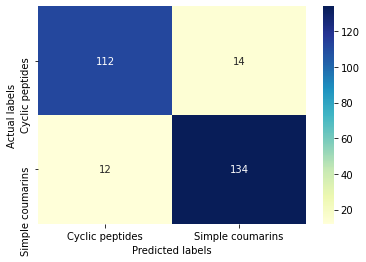

In [15]:
# Plot Confusion matrix

ax= plt.subplot()
df_cm = pd.DataFrame(conf_mat, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual labels'
df_cm.columns.name = 'Predicted labels'
# sns.set(font_scale=1.8)
sns.heatmap(df_cm, annot=True, ax = ax, cmap="YlGnBu", fmt='d',annot_kws={"size": 10})



## Take multi major groups to do LDA

In [27]:
# Select major groups
lbs = Counter(y_label)
lbs = {k:v for k,v in sorted(lbs.items(), key=lambda item: item[1], reverse=True)}
print(list(lbs.values())[1:31])
select_lbs = list(lbs.keys())[1:31]
print(select_lbs)

[557, 531, 394, 299, 279, 271, 259, 252, 247, 221, 221, 206, 182, 169, 167, 157, 153, 150, 145, 137, 129, 128, 127, 120, 113, 109, 109, 108, 103, 103]
['Cyclic peptides', 'Simple coumarins', 'Pyridine alkaloids', 'Dipeptides', 'Flavones', 'Flavonols', 'Oleanane triterpenoids', 'Carboline alkaloids', 'Triacylglycerols', 'Aminoacids', 'Glycerophosphocholines', 'Isoquinoline alkaloids', 'Cinnamic acids and derivatives', 'Linear peptides', 'Cholane steroids', 'Isoflavones', 'Carotenoids (C40', 'Chalcones', 'Iridoids monoterpenoids', 'Corynanthe type', 'Flavanones', 'Simple indole alkaloids', 'Pregnane steroids', 'Simple phenolic acids', 'Piperidine alkaloids', 'Tripeptides', 'Phenylalanine-derived alkaloids', 'N-acyl amines', 'Anthraquinones and anthrones', 'Furocoumarins']


In [28]:
# Define the data

select_index = []
for i in select_lbs:
    temp_index, = np.where(y_label==i)
    #print(temp_index)
    select_index += list(temp_index)
select_index.sort()
#print(select_index)

y_label_2_main = np.array(y_label[select_index])
print(y_label_2_main.shape)

X_embedding_2_lbs=X_embedding[select_index,:]
print(X_embedding_2_lbs.shape)

(6146,)
(6146, 300)


In [29]:
### Perform LDA
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_embedding_2_lbs, y_label_2_main, test_size = 0.25, random_state = 0)
# Apply Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Apply LDA
t0=time.process_time()
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train,y_train)
t1=time.process_time()-t0
print('Time elapsed: %.3f' % t1)

# Predict the test set results and check the accuracy
y_pred = lda_model.predict(X_test)
accuracy_lda = accuracy_score(y_test,y_pred)
print('Accuracy: %.3f' % accuracy_lda)
conf_mat = confusion_matrix(y_test,y_pred)
#print(conf_mat.shape)

Time elapsed: 5.201
Accuracy: 0.528


<AxesSubplot:xlabel='Predicted labels', ylabel='Actual labels'>

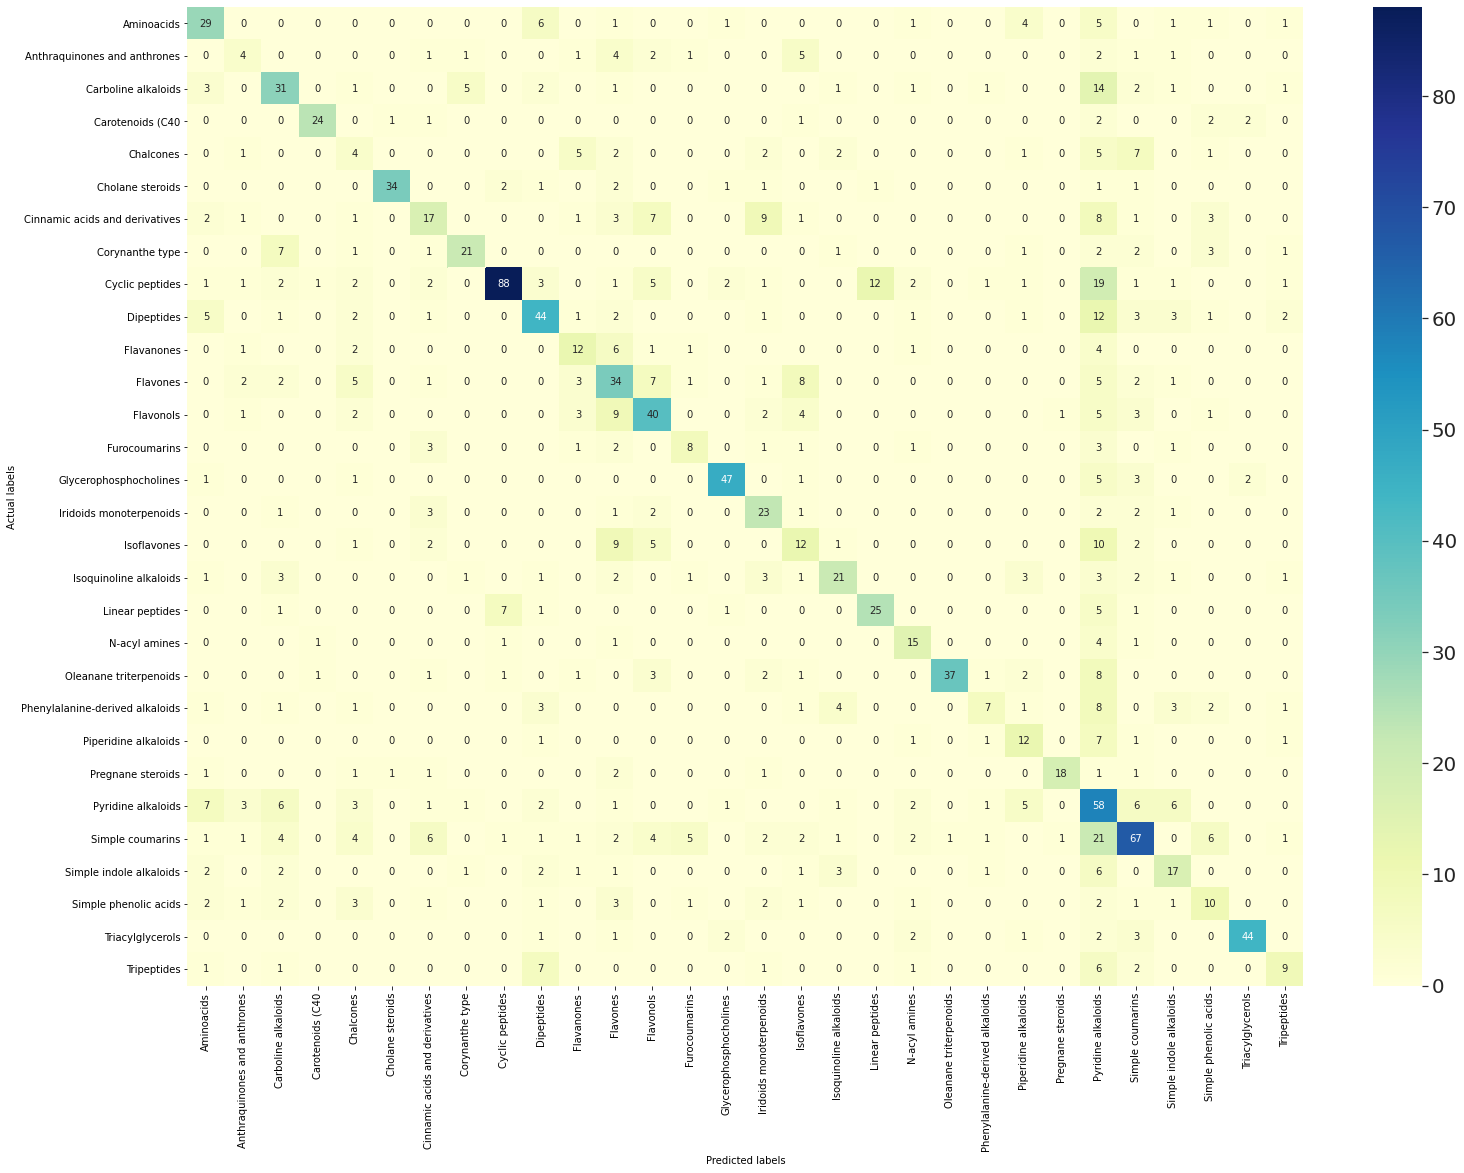

In [19]:
# Plot Confusion matrix
plt.figure(figsize = (25,18))
ax= plt.subplot()
df_cm = pd.DataFrame(conf_mat, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual labels'
df_cm.columns.name = 'Predicted labels'
sns.set(font_scale=1.8)
sns.heatmap(df_cm, annot=True, ax = ax, cmap="YlGnBu", fmt='d',annot_kws={"size": 10})



57 50
16 23
64 64
27 33
34 30
36 44
42 54
30 40
100 147
76 80
30 28
90 72
76 71
18 21
55 60
52 36
41 42
35 44
38 41
31 23
38 58
14 33
32 24
20 27
235 104
115 135
38 37
30 32
48 56
19 28


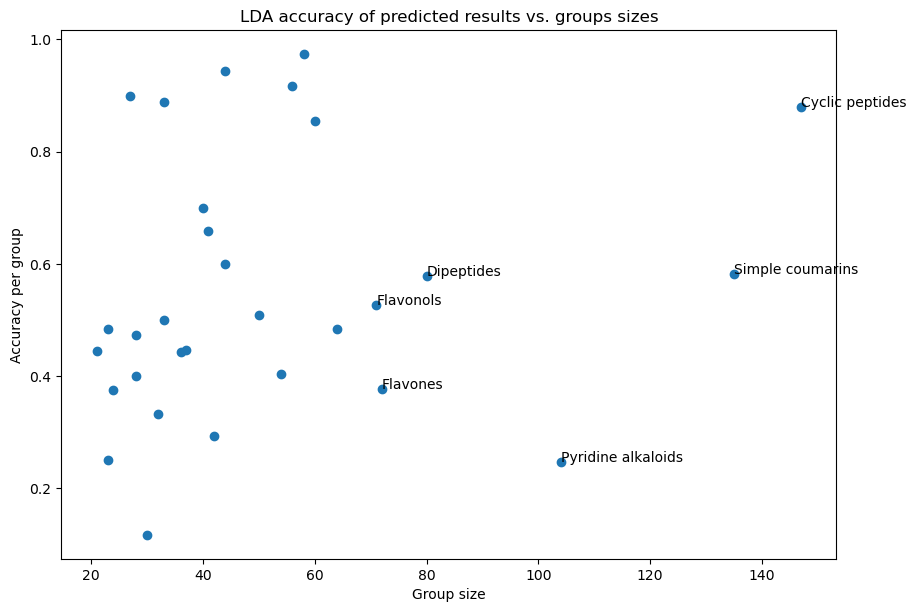

In [30]:
#from calculate_accuracy19 import calculate_accuracy_per_label

labels_a = list(np.unique(np.array(list(y_test)+list(y_pred))))
accuracy_dict = calculate_accuracy_per_label(labels_a, conf_mat,list(y_train))

save_accuracy_file = open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label/NPC_accuracy_LDA_Class_30groups.pickle', "wb")
pickle.dump(accuracy_dict, save_accuracy_file)
save_accuracy_file.close()

x= accuracy_dict['group_size_test']
y= accuracy_dict['accuracy']
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':100})
plt.scatter(x, y)
plt.title('LDA accuracy of predicted results vs. groups sizes')
plt.xlabel('Group size')
plt.ylabel('Accuracy per group')
for i,txt in enumerate(labels_a):
    if x[i] > 65:
        plt.annotate(txt,(x[i],y[i]))
plt.show()

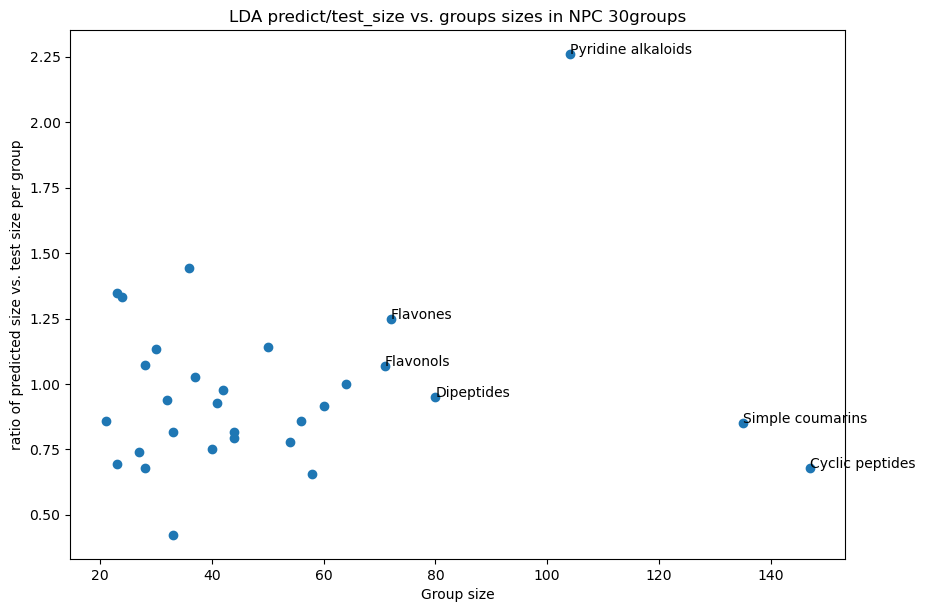

In [21]:
x= accuracy_dict['group_size_test']
y= accuracy_dict['predict_vs_test_size']
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':100})
plt.scatter(x, y)
plt.title('LDA predict/test_size vs. groups sizes in NPC 30groups')
plt.xlabel('Group size')
plt.ylabel('ratio of predicted size vs. test size per group')
for i,txt in enumerate(labels_a):
    if x[i] > 65:
        plt.annotate(txt,(x[i],y[i]))
plt.show()